# Mounting the drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Reading the data for Rabindra sangeet

In [ ]:
with open('/content/drive/MyDrive/ML Project/Bengali Lyrics/R_T_lyrics.txt') as f:
    data=f.read()

# Fetching the weight file from Drive

In [ ]:
import shutil

shutil.copyfile('/content/drive/MyDrive/ML Project/LSTM_weights/best_86.hdf5' , 'best.hdf5')

'best.hdf5'

# Importing necessary Libraries

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional,Conv1D, GlobalMaxPooling1D , MaxPooling1D ,BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
#from keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku 
import numpy as np 
import tensorflow as tf
#from imblearn.keras import balanced_batch_generator
#from imblearn.keras import BalancedBatchGenerator
from imblearn.under_sampling import NearMiss
#from balanced_batch_generator import balanced_batch_generator
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow.keras.backend as K
#from sklearn.utils import class_weight


# Defining the DATA

In [ ]:
print(data)

# Creating the word index using Tokenizer

In [ ]:
l_end = []
l_start = []
tokenizer = Tokenizer()
corpus = data.split("\n")
tokenizer.fit_on_texts(corpus) 
total_words = len(tokenizer.word_index) + 1


input_sequences = []
for line in corpus:
	word=line.split()
	if len(word)!= 0 :
  		l_end.append(word[-1])
  		l_start.append(word[0])

	token_list = tokenizer.texts_to_sequences([line])[0] 

	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]

		input_sequences.append(n_gram_sequence)
max_sequence_len = max([len(x) for x in input_sequences])

input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre')) 

predictors, label = input_sequences[:,:-1],input_sequences[:,-1]
print(predictors.shape)

classes_instance= np.bincount(label)
num_classes = len(classes_instance)



label = ku.to_categorical(label, num_classes=num_classes)



(7726, 12)


In [ ]:
word_index = tokenizer.word_index
word_index


# Modifying the Tokenizer to reduce number of calsses and pre-process the data to fit in Model

#Comute class weights for next line model

In [ ]:
def compute_weight(Y, classes):
    Y = np.asarray(Y)
    num_samples = len(Y)
    n_classes = len(classes)
    Y = Y.astype(int)
    Y = np.expand_dims(Y, axis=1)
    num_bin = np.bincount(Y[:, 0])
    class_weights={}
    for i in range(n_classes):
        if num_bin[i]!=0:
            class_weights[i]=(num_samples / (n_classes * num_bin[i]))
        else:
            class_weights[i]=1 
    return class_weights

# Preparing data for the next line model

In [ ]:
text=[]

for each_line in data.split('\n'):
    each_line = each_line+'\n'
    text.append(each_line)

while True:
    try:
        text.remove('\n')
    except:
        break


char_tokenizer = Tokenizer(char_level=True,oov_token="UNK")
char_tokenizer.fit_on_texts(text)

next_line_token = char_tokenizer.word_index['\n']
total_character = len(char_tokenizer.word_index.keys())

sequences = char_tokenizer.texts_to_sequences(text)

X=[]
Y=[]
for each_sequence in sequences:
    for i in range(1,len(each_sequence)):
        if each_sequence[i]!=next_line_token and each_sequence[i+1]!=next_line_token:
            X.append(each_sequence[:i+1])
            Y.append(0)
        else:
            X.append(each_sequence[:i+1])
            Y.append(1)
            break
max_seq_length = max([len(i) for i in X])

X = np.array(pad_sequences(X, maxlen=max_seq_length, padding='post'))

Y = np.asarray(Y)
class_weight = compute_weight(Y, [0,1])



# Next Word Model

In [ ]:

tf.random.set_seed(10)

model_3 = Sequential()
model_3.add(Embedding(total_words, 120, input_length=max_sequence_len-1))
model_3.add(Bidirectional(LSTM(170, return_sequences = True)))

model_3.add(Conv1D(filters=64, kernel_size=3,padding='valid'))
model_3.add(BatchNormalization())
model_3.add(MaxPooling1D(pool_size=2))
model_3.add(Dropout(0.2))
model_3.add(LSTM(150,return_sequences=True))
model_3.add(LSTM(150))

model_3.add(Dense(total_words/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_3.add(Dense(num_classes, activation='softmax'))
adam = Adam(learning_rate=0.001)

model_3.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
print(model_3.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 12, 120)           404880    
                                                                 
 bidirectional (Bidirectiona  (None, 12, 340)          395760    
 l)                                                              
                                                                 
 conv1d (Conv1D)             (None, 10, 64)            65344     
                                                                 
 batch_normalization (BatchN  (None, 10, 64)           256       
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 5, 64)            0         
 )                                                               
                                                        

# 2nd model to predict next line in the lyrics

In [ ]:
model2 = Sequential()
model2.add(Embedding(total_character+1, 120, input_length=max_seq_length))
model2.add(Conv1D(filters=64, kernel_size=3,padding='valid'))
model2.add(GlobalMaxPooling1D())
model2.add(Dense(10, activation='relu'))
model2.add(Dense(1, activation='sigmoid'))
model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
print(model2.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 64, 120)           9480      
                                                                 
 conv1d_1 (Conv1D)           (None, 62, 64)            23104     
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_2 (Dense)             (None, 10)                650       
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 33,245
Trainable params: 33,245
Non-trainable params: 0
__________________________________________________

# Training Next line model

In [ ]:

K.set_value(model2.optimizer.learning_rate, 0.001)




filepath = "best_next_line_model.hdf5"
model_checkpoint = ModelCheckpoint(filepath, monitor="accuracy", save_best_only=True, verbose=1)
history = model2.fit(X, Y, batch_size=128, epochs=1000 , verbose=1, callbacks=[model_checkpoint], class_weight=class_weight)


Epoch 1/1000
387/387 [==============================] - ETA: 0s - loss: 0.4255 - accuracy: 0.7726
Epoch 1: accuracy improved from -inf to 0.77261, saving model to best_next_line_model.hdf5
387/387 [==============================] - 13s 6ms/step - loss: 0.4255 - accuracy: 0.7726
Epoch 2/1000
382/387 [============================>.] - ETA: 0s - loss: 0.2879 - accuracy: 0.8776
Epoch 2: accuracy improved from 0.77261 to 0.87813, saving model to best_next_line_model.hdf5
387/387 [==============================] - 2s 6ms/step - loss: 0.2876 - accuracy: 0.8781
Epoch 3/1000
387/387 [==============================] - ETA: 0s - loss: 0.2543 - accuracy: 0.8871
Epoch 3: accuracy improved from 0.87813 to 0.88710, saving model to best_next_line_model.hdf5
387/387 [==============================] - 2s 6ms/step - loss: 0.2543 - accuracy: 0.8871
Epoch 4/1000
382/387 [============================>.] - ETA: 0s - loss: 0.2349 - accuracy: 0.8998
Epoch 4: accuracy improved from 0.88710 to 0.89947, saving mo

# Training the lyric/word prediction model

In [ ]:
list_of_training = ["model_3"]

K.set_value(model_3.optimizer.learning_rate, 0.001)
for each_model in list_of_training:
    filepath = f"best_{each_model}.hdf5"
    model_checkpoint = ModelCheckpoint(filepath, monitor="loss", save_best_only=True, verbose=1)

    if each_model == "model_1":
        history = model_1.fit(predictors, label,batch_size=1024, epochs=4000 , verbose=1, callbacks=[model_checkpoint])
    elif each_model == "model_2":
        history = model_2.fit(predictors, label,batch_size=1024, epochs=4000 , verbose=1, callbacks=[model_checkpoint])
    elif each_model == "model_3":
        history = model_3.fit(predictors, label,batch_size=1024, epochs=4000 , verbose=1, callbacks=[model_checkpoint])




Streaming output truncated to the last 5000 lines.
Epoch 2751/4000
7/8 [=========================>....] - ETA: 0s - loss: 0.4905 - accuracy: 0.8862
Epoch 2751: loss did not improve from 0.33690
8/8 [==============================] - 0s 56ms/step - loss: 0.4962 - accuracy: 0.8844
Epoch 2752/4000
7/8 [=========================>....] - ETA: 0s - loss: 0.4646 - accuracy: 0.8905
Epoch 2752: loss did not improve from 0.33690
8/8 [==============================] - 0s 53ms/step - loss: 0.4697 - accuracy: 0.8888
Epoch 2753/4000
7/8 [=========================>....] - ETA: 0s - loss: 0.4521 - accuracy: 0.8924
Epoch 2753: loss did not improve from 0.33690
8/8 [==============================] - 0s 51ms/step - loss: 0.4534 - accuracy: 0.8913
Epoch 2754/4000
7/8 [=========================>....] - ETA: 0s - loss: 0.4271 - accuracy: 0.8961
Epoch 2754: loss did not improve from 0.33690
8/8 [==============================] - 0s 56ms/step - loss: 0.4305 - accuracy: 0.8943
Epoch 2755/4000
7/8 [============

# Plotting the training graphs 

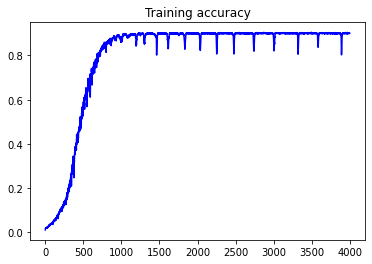

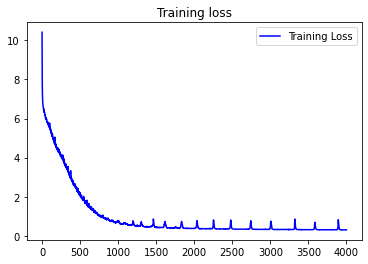

In [ ]:
import matplotlib.pyplot as plt
accuracy = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

# Output the Lyrics 

In [ ]:
#model_3.load_weights('/content/drive/My Drive/Colab Notebooks/R_T/best_model_3.hdf5')
model_3.load_weights('/content/best_model_3.hdf5')
model2.load_weights('/content/best_next_line_model.hdf5')
#model2.load_weights('/content/drive/My Drive/Colab Notebooks/R_T/best_next_line_model.hdf5')
seed_text = "চোখের আলো  "
#count=0

#prv_last=""
first_word_seed_text=""
lines = 10
i=0
prediction_probabilities = []
while i < lines :
    if first_word_seed_text == "":

        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        predicted = model_3.predict(token_list, verbose=0)
    else:
        token_list = tokenizer.texts_to_sequences([first_word_seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        predicted = model_3.predict(token_list, verbose=0)
        first_word_seed_text = ""
    predicted_class = np.argmax(predicted)
    prediction_probabilities.append(predicted[0][predicted_class])
    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted_class:
            output_word = word
            break

    if seed_text.find(output_word) == -1:
        seed_text += output_word + " "
    else:
        predicted_class = np.argsort(predicted)[0][-2]
    
        for word, index in tokenizer.word_index.items():
            if index == predicted_class:         
                output_word = word
                break
        

        seed_text +=  output_word + " "

    next_line_seed_text = seed_text.split('\n')[-1]
    if next_line_seed_text == "":
        next_line_seed_text = seed_text
    char_token_list = char_tokenizer.texts_to_sequences([next_line_seed_text])
    char_token_list = np.array(pad_sequences(char_token_list, maxlen=max_seq_length, padding='post'))
    predicted_next_line = model2.predict(char_token_list, verbose=0)[0][0]
    if predicted_next_line >= 0.5:
        seed_text += "\n"
        i += 1
        first_word_seed_text = next_line_seed_text
    

    

		
print(seed_text)


চোখের আলো  পথের তলে দুরে 
তোমার ছল কতই সে যেই দান আর না কভু অণু ঠেকাবে 
তোমাকে গো’ ব’লে কানে কখন যা 
মেঘের কথা রে দিল আমায় আর আর আমায় দিকে তাহা হৃদয় হারাইয়া 
বাঁধন যত আনন্দে ঘিরি বন্দে উড়ে আসবে চায় 
তখন নিদয়া কোলে দ্বার তোমারে হয় হে নামে 
মেঘের আসে গো বাসা পাওয়া ভালোবেসে না পারে 
দোলে বাণে না গান কে খানে নয় 
ঘর দেখালে পানে লাগে হে কোলে সমীরণে 
কোথা সমীরণে ভবের আকাশ ধরার খোলা রাখিতে আমার– কোলে ঝর্ঝর সেই জানে আর ভাই বাঁধন সকল নামে 



In [ ]:
import pandas as pd
col_list = ["Starting", "Self -BLEU(GPT-2)","SELF_BLEU(LSTM)"]
df = pd.read_csv("/content/drive/MyDrive/ML Project/result - Sheet1.csv", usecols=col_list)

print(df["Starting"][1])
print(len(df["Starting"]))

আজি বর্ষায়
50


In [ ]:
#####all songs together#####
#model_3.load_weights('/content/drive/My Drive/Colab Notebooks/R_T/best_model_3.hdf5')
model_3.load_weights('/content/best_model_3.hdf5')
model2.load_weights('/content/best_next_line_model.hdf5')
#model2.load_weights('/content/drive/My Drive/Colab Notebooks/R_T/best_next_line_model.hdf5')
col_list = ["Starting", "Self -BLEU(GPT-2)","SELF_BLEU(LSTM)"]
df = pd.read_csv("/content/drive/MyDrive/ML Project/result - Sheet1.csv", usecols=col_list)

#print(df["Starting"])
for j in range(len(df["Starting"])):
    seed_text = df["Starting"][j]
#count=0

#prv_last=""
    first_word_seed_text=""
    lines = 10
    i=0
    prediction_probabilities = []
    while i < lines :
        if first_word_seed_text == "":

            token_list = tokenizer.texts_to_sequences([seed_text])[0]
            token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
            predicted = model_3.predict(token_list, verbose=0)
        else:
            token_list = tokenizer.texts_to_sequences([first_word_seed_text])[0]
            token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
            predicted = model_3.predict(token_list, verbose=0)
            first_word_seed_text = ""
        predicted_class = np.argmax(predicted)
        prediction_probabilities.append(predicted[0][predicted_class])
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted_class:
                output_word = word
                break

        if seed_text.find(output_word) == -1:
            seed_text += output_word + " "
        else:
            predicted_class = np.argsort(predicted)[0][-2]
           
            for word, index in tokenizer.word_index.items():
                if index == predicted_class:         
                    output_word = word
                    break
        

            seed_text +=  output_word + " "

        next_line_seed_text = seed_text.split('\n')[-1]
        if next_line_seed_text == "":
            next_line_seed_text = seed_text
        char_token_list = char_tokenizer.texts_to_sequences([next_line_seed_text])
        char_token_list = np.array(pad_sequences(char_token_list, maxlen=max_seq_length, padding='post'))
        predicted_next_line = model2.predict(char_token_list, verbose=0)[0][0]
        if predicted_next_line >= 0.5:
            seed_text += "\n"
            i += 1
            first_word_seed_text = next_line_seed_text
    

    

    path = "/content/drive/MyDrive/ML Project/LSTM_outputs/song" + str(j) + ".txt"
    f = open(path, "w")
    f.writelines(seed_text)
    f.close()
